In [818]:
import simpy
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import pandas as pd
import time
from scipy import stats
import heapq
import warnings
import matplotlib.gridspec as gridspec



Queuing theory tells us that for FIFO scheduling the average waiting times are shorter for an
$M/M/n$ queue and a system load $\rho$ and processor capacity $\mu$ than for a single $M/M/1$ queue
with the same load characteristics (and thus an n-fold lower arrival rate). Of course, $\rho$ must be
less than one, but the experiment only becomes interesting when $\rho$ is not much less than one.

$\lambda$ then becomes $\lambda = \rho*n*\mu$.

Code sources: "https://simpy.readthedocs.io/en/latest/examples/bank_renege.html" and "https://www.youtube.com/watch?v=eSNfC-HOl44"

In [822]:
# M/M/1 (M/M/n) queueing system
def generate_interarrival(mu,n,rho):
    return random.expovariate(mu*n*rho)


def source(env, n, rho, mu, servers):
    """Source generates customers randomly based on exponential distribution"""
    i = 0
    while True:
        i += 1
        c = customer(env, i, servers, mu)
        env.process(c)
        t = random.expovariate(mu*n*rho)
        yield env.timeout(t)   

total_waiting_time = []

def customer(env, customer, servers, mu):
    """This generator function models the behavior of a customer in the queue."""
    time_of_arrival = env.now
    with servers.request() as req:    
        yield req
        time_of_handling = random.expovariate(mu)
        #print(env.now, 'customer {} is being served'.format(customer))
        yield env.timeout(time_of_handling)
        waiting_time = env.now
        #print(env.now, 'customer {} departs'.format(customer))
        total_waiting_time.append(waiting_time-time_of_arrival)

### Setup and start the simulation

# Initial values            
mu = 1  # Parameter mu
rho = 0.9 #[0.7,0.85,0.9,0.95,0.99] # Parameter rho (varying for values close to 1)
n = 2 # Number of servers, in our case 1, 2 and 4

env = simpy.Environment()

# Start processes and run
servers = simpy.Resource(env, capacity=n)
env.process(source(env, n, rho, mu, servers))
env.run(until=200)
print(f"Total customers served: {len(total_waiting_time)}")
print(f"Average waiting time: {sum(total_waiting_time) / len(total_waiting_time) if total_waiting_time else 0}")

Total customers served: 364
Average waiting time: 2.7143156823916983


In [6]:
# Defining function for simulating M/M/n queue system

# Setup and start the simulation
def sim_run(n,rho,mu,sim_duration):
    env = simpy.Environment()
    # Start processes and run
    servers = simpy.Resource(env, capacity=n)
    env.process(source(env, n, rho, mu, servers))
    env.run(until=sim_duration)
    
# Looping over the simulation and extracting mean and standard deviation
# Initial values
sim_duration = 500     
mu = 1  # Parameter mu
rho_vals = [0.9,0.95] #[0.7,0.85,0.92,0.95,0.99]
n = [1] #[1,2,4]
# Running simulation to calculate mean
sim_runs = 20
data = []

for n_servers in n:
    for rho in rho_vals:
        for i in range(sim_runs):
            total_waiting_time = []
            sim_run(n=n_servers, rho=rho, mu=mu, sim_duration=sim_duration)
            averages = np.concatenate((np.arange(100, 1000, 100), np.arange(1000, 10000, 1000), np.arange(10000, 100001, 10000)))
            df = pd.DataFrame({
                'run': [i] * len(averages),
                'rho': [rho] * len(averages),
                'number of servers': [n_servers] * len(averages),
                'number of customers': averages,
                'average waiting time': [np.mean(total_waiting_time[:n_customers]) for n_customers in averages]
            })
            data.append(df)

        print(f'rho={rho} for server number {n_servers} finished')

# Concatenate the list of DataFrames
result_df = pd.concat(data, ignore_index=True)    

rho=0.9 for server number 1 finished
rho=0.95 for server number 1 finished


In [ ]:
# Plot the mean and standard deviation of the waiting time

SJF implementation

non-preemptive SJF

In [435]:
def source(env, mu, n, rho, queue, q_arr):
    """Function that summons people and pushes them to the heap queue (each parent has higher priority that his two children)."""
    while True:
        #Create a service time
        time_of_handling = random.expovariate(mu)
        arrival_time = env.now
        heapq.heappush(queue, (time_of_handling, arrival_time))
        #Time to next customer
        tm = random.expovariate(mu*n*rho)        
        q_arr.append((env.now, len(queue)))
        yield env.timeout(tm)

def do_work(env, client, servers, time_to_finish, total_waiting_time):
    """ Function that processes the customer by yielding timeout and equesting resource"""
    with servers.request() as req:
        yield req
        yield env.timeout(time_to_finish)
        #Total waiting time
        total_waiting_time.append((env.now,env.now - client))


def customer_initialise(env, servers, queue, total_waiting_time, q_arr):
    while True:
        # Check if there is que and if any resourses are free
        if queue and servers.count < servers.capacity:
                time_to_finish, client = heapq.heappop(queue)
                env.process(do_work(env, client, servers, time_to_finish, total_waiting_time))
                q_arr.append((env.now, len(queue)))
                #Timeout to not send all people from my queue to the buildin Simpy fcfs queue and check "if queue and servers.count < servers.capacity:" again
                yield env.timeout(0.001)
        else:
            #Timeout to not be stuck in the loop
            yield env.timeout(0.01)


mu = 1.0          
n = 4             
rho = 1       
sim_time = 200    
env = simpy.Environment()
servers = simpy.Resource(env,capacity=n)
priority_queue = []
total_waiting_time = []
q_arr = []
print(priority_queue)
env.process(source(env, mu, n, rho, priority_queue, q_arr))
env.process(customer_initialise(env, servers, priority_queue, total_waiting_time, q_arr))
env.run(until=sim_time)
print(f"Total customers served: {len(total_waiting_time)}")


[]
Total customers served: 828


preemptive SJF (halting the precesses if faster customer arrives)

In [739]:
#Here I created client class so it is more convinient to resend someone back to the que and rember his time_of_handling that is left
class Client:
    def __init__(self, time_of_arrival, time_of_handling):
        self.time_of_arrival = time_of_arrival
        self.time_of_handling = time_of_handling

def source_preemptive(env, mu, n, rho, queue, q_arr):
    while True:
        time_of_handling = random.expovariate(mu)
        arrival_time = env.now
        heapq.heappush(queue, (time_of_handling, Client(arrival_time, time_of_handling)))
        q_arr.append((env.now, len(queue)))
        yield env.timeout(random.expovariate(mu*n*rho))

def do_work_preemptive(env, client, servers, time_to_finish, total_waiting_time, queue):
    with servers.request() as req:
        yield req
        #It should be the last time someone is processed
        if time_to_finish <= 0.1:
            yield env.timeout(time_to_finish)
            #Record total waiting time
            total_waiting_time.append((env.now, env.now - client.time_of_arrival))
        else:
            #Here I resend someone to the queue and sice it is heap queue if he has the least waiting time he will be processed next or someone with less waiting time
            yield env.timeout(0.1)
            arrival_time = client.time_of_arrival
            time_of_handling = client.time_of_handling - 0.1
            heapq.heappush(queue, (time_of_handling, Client(arrival_time, time_of_handling)))
            
def customer_initialise_preemptive(env, servers, queue, total_waiting_time, q_arr):
    while True:
        if queue and servers.count < servers.capacity:
            time_to_finish, client = heapq.heappop(queue)
            env.process(do_work_preemptive(env, client, servers, time_to_finish, total_waiting_time, queue))
            q_arr.append((env.now, len(queue)))
            yield env.timeout(0.002)
        else:
            yield env.timeout(0.01)


    

mu = 1.0         
n = 2             
rho = 0.95         
sim_time = 150
env = simpy.Environment()
servers = simpy.Resource(env,capacity=n)
priority_queue = []
total_waiting_time = []
mean_queue = []
mean_waiting_time = []
q_arr = [] 
env.process(source_preemptive(env, mu, n, rho, priority_queue, q_arr))
env.process(customer_initialise_preemptive(env, servers, priority_queue, total_waiting_time, q_arr))
env.run(until=sim_time)
print(f"Que length mean: {len(q_arr)}")
print(f"Total customers served: {len(total_waiting_time)}")

Que length mean: 3226
Total customers served: 278


#3 Data analysis

In [639]:
warnings.simplefilter(action='ignore', category=FutureWarning)
def sim_run(n,rho,mu,sim_time):
    """Function to run a simulation"""
    env = simpy.Environment()
    servers = simpy.Resource(env,capacity=n)
    priority_queue = []
    total_waiting_time = []
    q_arr = [] 
    env.process(source(env, mu, n, rho, priority_queue, q_arr))
    env.process(customer_initialise(env, servers, priority_queue, total_waiting_time, q_arr))
    env.run(until=sim_time)
    return total_waiting_time, q_arr

mean_queue_lengths = pd.DataFrame()
rho_vals = [0.85,0.9,0.95,0.99]
serv = [1, 2, 4]
sim_time = 20000
mu = 1.0         
all_results = []
second_data_que = []
mean_vaiting = []
all_results_mean = []
z_score = 1.96
mean_std_ci_queue_lengths = pd.DataFrame()
mean_std_ci_waiting_time = pd.DataFrame()
waiting_time_general_stat = pd.DataFrame()
simulations = 100
# The loops to go through numb. of servers and p value
for server in serv:
    for p_value in rho_vals:
        #I defne all arrays and vars that are reused for each params.
        second_data_que = []
        mean_vaiting = []
        mean_waiting_data_for_statistics = []
        std_waiting_data_for_statistics = []
        customers_srvd_stat = []
        queue_stat = []
        maxim = -np.inf
        minim = np.inf
        maxim_que = -np.inf
        minim_que = np.inf
        maxim_customers_served = -np.inf
        minim_customers_served = np.inf
        #Run simulations
        for run in range(simulations):
            #Run and extract data from simulation 
            waiting_data, queue_data = sim_run(server,p_value,mu,sim_time)
            #Here I calculate everything for dataframe that is needed to calculate overall atatistics for n simulations
            f = lambda a: a[1]
            waiting_data_true = list(map(f, waiting_data))
            queue_data_true = list(map(f, queue_data))
            mean_queue_cur_sim = np.mean(queue_data_true)
            mean_waiting_cur_sim = np.mean(waiting_data_true)
            max_waiting = np.max(waiting_data_true)
            maxim = max(max_waiting, maxim)
            min_waiting = np.min(waiting_data_true)
            minim = min(min_waiting, minim)
            max_que = np.max(queue_data_true)
            maxim_que = max(max_que, maxim_que)
            min_que = np.min(queue_data_true)
            minim_que = min(min_que, minim_que)
            customer_served = len(waiting_data_true)
            maxim_customers_served = max(customer_served, maxim_customers_served)
            minim_customers_served = min(customer_served, minim_customers_served)
            std_within_sim_waiting = np.std(waiting_data_true)
            mean_waiting_data_for_statistics.append(mean_waiting_cur_sim)
            std_waiting_data_for_statistics.append(std_within_sim_waiting)
            queue_stat.append(mean_queue_cur_sim)
            customers_srvd_stat.append(customer_served)
            # Here I create dataframes for interday statistics for n sims
            df_queue = pd.DataFrame(queue_data, columns=['Time', 'Queue_Length'])
            df_queue['Time'] = df_queue['Time'].round().astype(int) // 100
            df_second_mean = df_queue.groupby('Time').mean()
            second_data_que.append(df_second_mean)
            df_waiting = pd.DataFrame(waiting_data, columns=['Time', 'Waiting_time'])
            df_waiting['Time'] = df_waiting['Time'].round().astype(int) // 100
            df_waiting_mean = df_waiting.groupby('Time').mean()
            mean_vaiting.append(df_waiting_mean)
        #All calculations related to daily dataframes. Basically two dtatframes with mean value for every 100 days 
        for second in range(0, int(sim_time/100)):
            interval_data = [pd.Series(df.loc[second]['Queue_Length']) if second in df.index else pd.Series([0]) for df in second_data_que]
            concatenated_data = pd.concat(interval_data, ignore_index=True)
            mean_length = concatenated_data.mean()
            std_dev = concatenated_data.std()
            margin_of_error = z_score * (std_dev / np.sqrt(len(concatenated_data)))
            lower_bound = mean_length - margin_of_error
            upper_bound = mean_length + margin_of_error
            mean_std_ci_queue_lengths = mean_std_ci_queue_lengths._append({
                'Server_Count': server, 
                'P_Value': p_value, 
                'Time_Second': (second+1)*100,
                'Mean_Queue_Length': mean_length,
                'Std_Dev_Queue_Length': std_dev,
                'CI_Lower_Bound': lower_bound,
                'CI_Upper_Bound': upper_bound
            }, ignore_index=True)
            interval_data_waiting = [pd.Series(df.loc[second]['Waiting_time']) if second in df.index else pd.Series() for df in mean_vaiting]
            concatenated_data_waiting = pd.concat(interval_data_waiting, ignore_index=True)
            mean_length_waiting = concatenated_data_waiting.mean()
            std_dev_waiting = concatenated_data_waiting.std()
            confidence_waiting_time = z_score * (std_dev_waiting / np.sqrt(len(concatenated_data_waiting)))
            lower_bound_waiting = mean_length_waiting - confidence_waiting_time
            upper_bound_waiting = mean_length_waiting + confidence_waiting_time
            mean_std_ci_waiting_time = mean_std_ci_waiting_time._append({
                'Server_Count': server, 
                'P_Value': p_value, 
                'Time_Second': (second+1)*100,
                'Mean_Waiting_time': mean_length_waiting,
                'Std_Dev_Waiting_time': std_dev_waiting,
                'CI_Lower_Bound': lower_bound_waiting,
                'CI_Upper_Bound': upper_bound_waiting
            }, ignore_index=True)
        # All calculations for overall statistics over 100 simulations
        whole_sim_mean = np.mean(mean_waiting_data_for_statistics) 
        whole_sim_within_std = np.mean(std_waiting_data_for_statistics)
        std_whole_sim = np.std(mean_waiting_data_for_statistics)  
        std_fr_std_whole_sim = np.std(std_waiting_data_for_statistics)  
        confidence_waiting_time_whole = z_score * (std_whole_sim / np.sqrt(len(mean_waiting_data_for_statistics)))
        lower_bound_waiting_whole = whole_sim_mean - confidence_waiting_time_whole
        upper_bound_waiting_whole = whole_sim_mean + confidence_waiting_time_whole   
        confidence_waiting_std_within = z_score * (std_fr_std_whole_sim / np.sqrt(len(std_waiting_data_for_statistics)))
        lower_bound_waiting_std_within = whole_sim_within_std - confidence_waiting_std_within
        upper_bound_waiting_std_within = whole_sim_within_std + confidence_waiting_std_within 
        customers_served_mean = np.mean(customers_srvd_stat)
        customers_served_std = np.std(customers_srvd_stat)
        confidence_customers_served = z_score * (customers_served_std / np.sqrt(len(customers_srvd_stat)))
        lower_bound_customers_served = customers_served_mean - confidence_customers_served
        upper_bound_customers_served = customers_served_mean + confidence_customers_served 
        mean_que = np.mean(queue_stat)
        std_que = np.mean(queue_stat)
        confidence_que = z_score * (std_que / np.sqrt(len(queue_stat)))
        lower_bound_que = mean_que - confidence_que
        upper_bound_que = mean_que + confidence_que 
        waiting_time_general_stat = waiting_time_general_stat._append({
                'Server_Count': server, 
                'P_Value': p_value, 
                'Mean_Waiting_time': whole_sim_mean,
                'Mean_Within_Std_of_Waiting_time': whole_sim_within_std,
                'Customers_Served': customers_served_mean,
                'Mean_queue': mean_que,
                'Std_within_Waiting_time': std_fr_std_whole_sim,
                'Std_Dev_Waiting_time': std_whole_sim,
                'Std_Dev_Customers_served': customers_served_std,
                'Std_Dev_Queue': std_que,
                'CI_Lower_Bound_Mean': lower_bound_waiting_whole,
                'CI_Upper_Bound_Mean': upper_bound_waiting_whole,
                'CI_Lower_Bound_Std': lower_bound_waiting_std_within,
                'CI_Upper_Bound_Std': upper_bound_waiting_std_within, 
                'CI_Lower_Bound_Customers_Served': lower_bound_customers_served,
                'CI_Upper_Bound_Customers_Served': upper_bound_customers_served, 
                'CI_Lower_Bound_Queue': lower_bound_que,
                'CI_Upper_Bound_Queue': upper_bound_que, 
                'Min_waiting_time': minim,
                'Max_waiting_time': maxim,
                'Min_queue': minim_que,
                'Max_queue': maxim_que,
                'Min_customers_served': minim_customers_served,
                'Max_customers_served': maxim_customers_served
                }, ignore_index=True)



        


In [640]:
mean_std_ci_queue_lengths

,Server_Count,P_Value,Time_Second,Mean_Queue_Length,Std_Dev_Queue_Length,CI_Lower_Bound,CI_Upper_Bound
0,1.0,0.85,100.0,2.151051,1.027989,1.949565,2.352537
1,1.0,0.85,200.0,2.536258,1.146287,2.311586,2.760931
2,1.0,0.85,300.0,2.455223,1.213805,2.217318,2.693129
3,1.0,0.85,400.0,2.447869,1.257445,2.201410,2.694328
4,1.0,0.85,500.0,2.516431,1.402673,2.241507,2.791355
...,...,...,...,...,...,...,...
2395,4.0,0.99,19600.0,24.396679,19.716353,20.532274,28.261084
2396,4.0,0.99,19700.0,24.152049,19.864641,20.258579,28.045518
2397,4.0,0.99,19800.0,23.630416,19.948122,19.720584,27.540248
2398,4.0,0.99,19900.0,23.042219,19.667258,19.187436,26.897001


In [702]:
mean_std_ci_waiting_time

,Server_Count,P_Value,Time_Second,Mean_Waiting_time,Std_Dev_Waiting_time,CI_Lower_Bound,CI_Upper_Bound
0,1.0,0.85,100.0,2.706232,0.788832,2.551621,2.860843
1,1.0,0.85,200.0,3.296910,1.242321,3.053416,3.540405
2,1.0,0.85,300.0,3.488186,1.626989,3.169296,3.807076
3,1.0,0.85,400.0,3.161652,1.240723,2.918470,3.404834
4,1.0,0.85,500.0,3.553188,1.643720,3.231019,3.875358
...,...,...,...,...,...,...,...
2395,4.0,0.99,19600.0,6.541694,7.900897,4.993118,8.090269
2396,4.0,0.99,19700.0,7.581294,8.590206,5.897614,9.264974
2397,4.0,0.99,19800.0,6.288601,6.397468,5.034697,7.542504
2398,4.0,0.99,19900.0,7.190708,8.279467,5.567933,8.813484


In [710]:
waiting_time_general_stat.columns

Index(['Server_Count', 'P_Value', 'Mean_Waiting_time',
       'Mean_Within_Std_of_Waiting_time', 'Customers_Served', 'Mean_queue',
       'Std_within_Waiting_time', 'Std_Dev_Waiting_time',
       'Std_Dev_Customers_served', 'Std_Dev_Queue', 'CI_Lower_Bound_Mean',
       'CI_Upper_Bound_Mean', 'CI_Lower_Bound_Std', 'CI_Upper_Bound_Std',
       'CI_Lower_Bound_Customers_Served', 'CI_Upper_Bound_Customers_Served',
       'CI_Lower_Bound_Queue', 'CI_Upper_Bound_Queue', 'Min_waiting_time',
       'Max_waiting_time', 'Min_queue', 'Max_queue', 'Min_customers_served',
       'Max_customers_served'],
      dtype='object')

In [741]:
warnings.simplefilter(action='ignore', category=FutureWarning)
def sim_run(n,rho,mu,sim_time):
    """Function to run a simulation"""
    env = simpy.Environment()
    servers = simpy.Resource(env,capacity=n)
    priority_queue = []
    total_waiting_time = []
    q_arr = []
    env.process(source_preemptive(env, mu, n, rho, priority_queue, q_arr))
    env.process(customer_initialise_preemptive(env, servers, priority_queue, total_waiting_time, q_arr))
    env.run(until=sim_time)
    return total_waiting_time, q_arr

mean_queue_lengths = pd.DataFrame()
rho_vals = [0.85,0.9,0.95,0.99]
serv = [1, 2, 4]
sim_time = 20000
mu = 1.0         
all_results = []
second_data_que = []
mean_vaiting = []
all_results_mean = []
z_score = 1.96
mean_queue_lengths_non_pe = pd.DataFrame()
mean_std_ci_waiting_time_non_pre = pd.DataFrame()
waiting_time_general_stat_non_pre = pd.DataFrame()
simulations = 100
# The loops to go through numb. of servers and p value
for server in serv:
    for p_value in rho_vals:
        #I defne all arrays and vars that are reused for each params.
        second_data_que = []
        mean_vaiting = []
        mean_waiting_data_for_statistics = []
        std_waiting_data_for_statistics = []
        customers_srvd_stat = []
        queue_stat = []
        maxim = -np.inf
        minim = np.inf
        maxim_que = -np.inf
        minim_que = np.inf
        maxim_customers_served = -np.inf
        minim_customers_served = np.inf
        #Run simulations
        for run in range(simulations):
            #Run and extract data from simulation 
            waiting_data, queue_data = sim_run(server,p_value,mu,sim_time)
            #Here I calculate everything for dataframe that is needed to calculate overall atatistics for n simulations
            f = lambda a: a[1]
            waiting_data_true = list(map(f, waiting_data))
            queue_data_true = list(map(f, queue_data))
            mean_queue_cur_sim = np.mean(queue_data_true)
            mean_waiting_cur_sim = np.mean(waiting_data_true)
            max_waiting = np.max(waiting_data_true)
            maxim = max(max_waiting, maxim)
            min_waiting = np.min(waiting_data_true)
            minim = min(min_waiting, minim)
            max_que = np.max(queue_data_true)
            maxim_que = max(max_que, maxim_que)
            min_que = np.min(queue_data_true)
            minim_que = min(min_que, minim_que)
            customer_served = len(waiting_data_true)
            maxim_customers_served = max(customer_served, maxim_customers_served)
            minim_customers_served = min(customer_served, minim_customers_served)
            std_within_sim_waiting = np.std(waiting_data_true)
            mean_waiting_data_for_statistics.append(mean_waiting_cur_sim)
            std_waiting_data_for_statistics.append(std_within_sim_waiting)
            queue_stat.append(mean_queue_cur_sim)
            customers_srvd_stat.append(customer_served)
            # Here I create dataframes for interday statistics for n sims
            df_queue = pd.DataFrame(queue_data, columns=['Time', 'Queue_Length'])
            df_queue['Time'] = df_queue['Time'].round().astype(int) // 100
            df_second_mean = df_queue.groupby('Time').mean()
            second_data_que.append(df_second_mean)
            df_waiting = pd.DataFrame(waiting_data, columns=['Time', 'Waiting_time'])
            df_waiting['Time'] = df_waiting['Time'].round().astype(int) // 100
            df_waiting_mean = df_waiting.groupby('Time').mean()
            mean_vaiting.append(df_waiting_mean)
        #All calculations related to daily dataframes. Basically two dtatframes with mean value for every 100 days 
        for second in range(0, int(sim_time/100)):
            interval_data = [pd.Series(df.loc[second]['Queue_Length']) if second in df.index else pd.Series([0]) for df in second_data_que]
            concatenated_data = pd.concat(interval_data, ignore_index=True)
            mean_length = concatenated_data.mean()
            std_dev = concatenated_data.std()
            margin_of_error = z_score * (std_dev / np.sqrt(len(concatenated_data)))
            lower_bound = mean_length - margin_of_error
            upper_bound = mean_length + margin_of_error
            mean_queue_lengths_non_pe = mean_queue_lengths_non_pe._append({
                'Server_Count': server, 
                'P_Value': p_value, 
                'Time_Second': (second+1)*100,
                'Mean_Queue_Length': mean_length,
                'Std_Dev_Queue_Length': std_dev,
                'CI_Lower_Bound': lower_bound,
                'CI_Upper_Bound': upper_bound
            }, ignore_index=True)
            interval_data_waiting = [pd.Series(df.loc[second]['Waiting_time']) if second in df.index else pd.Series() for df in mean_vaiting]
            concatenated_data_waiting = pd.concat(interval_data_waiting, ignore_index=True)
            mean_length_waiting = concatenated_data_waiting.mean()
            std_dev_waiting = concatenated_data_waiting.std()
            confidence_waiting_time = z_score * (std_dev_waiting / np.sqrt(len(concatenated_data_waiting)))
            lower_bound_waiting = mean_length_waiting - confidence_waiting_time
            upper_bound_waiting = mean_length_waiting + confidence_waiting_time
            mean_std_ci_waiting_time_non_pre = mean_std_ci_waiting_time_non_pre._append({
                'Server_Count': server, 
                'P_Value': p_value, 
                'Time_Second': (second+1)*100,
                'Mean_Waiting_time': mean_length_waiting,
                'Std_Dev_Waiting_time': std_dev_waiting,
                'CI_Lower_Bound': lower_bound_waiting,
                'CI_Upper_Bound': upper_bound_waiting
            }, ignore_index=True)
        # All calculations for overall statistics over 100 simulations
        whole_sim_mean = np.mean(mean_waiting_data_for_statistics) 
        whole_sim_within_std = np.mean(std_waiting_data_for_statistics)
        std_whole_sim = np.std(mean_waiting_data_for_statistics)  
        std_fr_std_whole_sim = np.std(std_waiting_data_for_statistics)  
        confidence_waiting_time_whole = z_score * (std_whole_sim / np.sqrt(len(mean_waiting_data_for_statistics)))
        lower_bound_waiting_whole = whole_sim_mean - confidence_waiting_time_whole
        upper_bound_waiting_whole = whole_sim_mean + confidence_waiting_time_whole   
        confidence_waiting_std_within = z_score * (std_fr_std_whole_sim / np.sqrt(len(std_waiting_data_for_statistics)))
        lower_bound_waiting_std_within = whole_sim_within_std - confidence_waiting_std_within
        upper_bound_waiting_std_within = whole_sim_within_std + confidence_waiting_std_within 
        customers_served_mean = np.mean(customers_srvd_stat)
        customers_served_std = np.std(customers_srvd_stat)
        confidence_customers_served = z_score * (customers_served_std / np.sqrt(len(customers_srvd_stat)))
        lower_bound_customers_served = customers_served_mean - confidence_customers_served
        upper_bound_customers_served = customers_served_mean + confidence_customers_served 
        mean_que = np.mean(queue_stat)
        std_que = np.mean(queue_stat)
        confidence_que = z_score * (std_que / np.sqrt(len(queue_stat)))
        lower_bound_que = mean_que - confidence_que
        upper_bound_que = mean_que + confidence_que 
        waiting_time_general_stat_non_pre = waiting_time_general_stat_non_pre._append({
                'Server_Count': server, 
                'P_Value': p_value, 
                'Mean_Waiting_time': whole_sim_mean,
                'Mean_Within_Std_of_Waiting_time': whole_sim_within_std,
                'Customers_Served': customers_served_mean,
                'Mean_queue': mean_que,
                'Std_within_Waiting_time': std_fr_std_whole_sim,
                'Std_Dev_Waiting_time': std_whole_sim,
                'Std_Dev_Customers_served': customers_served_std,
                'Std_Dev_Queue': std_que,
                'CI_Lower_Bound_Mean': lower_bound_waiting_whole,
                'CI_Upper_Bound_Mean': upper_bound_waiting_whole,
                'CI_Lower_Bound_Std': lower_bound_waiting_std_within,
                'CI_Upper_Bound_Std': upper_bound_waiting_std_within, 
                'CI_Lower_Bound_Customers_Served': lower_bound_customers_served,
                'CI_Upper_Bound_Customers_Served': upper_bound_customers_served, 
                'CI_Lower_Bound_Queue': lower_bound_que,
                'CI_Upper_Bound_Queue': upper_bound_que, 
                'Min_waiting_time': minim,
                'Max_waiting_time': maxim,
                'Min_queue': minim_que,
                'Max_queue': maxim_que,
                'Min_customers_served': minim_customers_served,
                'Max_customers_served': maxim_customers_served
                }, ignore_index=True)

In [742]:
waiting_time_general_stat_non_pre

,Server_Count,P_Value,Mean_Waiting_time,Mean_Within_Std_of_Waiting_time,Customers_Served,Mean_queue,Std_within_Waiting_time,Std_Dev_Waiting_time,Std_Dev_Customers_served,Std_Dev_Queue,...,CI_Lower_Bound_Customers_Served,CI_Upper_Bound_Customers_Served,CI_Lower_Bound_Queue,CI_Upper_Bound_Queue,Min_waiting_time,Max_waiting_time,Min_queue,Max_queue,Min_customers_served,Max_customers_served
0,1.0,0.85,3.126343,11.365760,17001.20,2.111362,2.381135,0.220015,141.244611,2.111362,...,16973.516056,17028.883944,1.697535,2.525189,0.000643,1274.884857,0.0,22.0,16623.0,17438.0
1,1.0,0.90,4.182395,20.972909,17984.35,3.156649,5.556820,0.421372,135.044983,3.156649,...,17957.881183,18010.818817,2.537946,3.775352,0.000473,2339.220833,0.0,29.0,17608.0,18292.0
2,1.0,0.95,8.260296,77.062443,19021.13,7.493724,39.640747,2.210317,134.307011,7.493724,...,18994.805826,19047.454174,6.024954,8.962494,0.000352,13241.330108,0.0,48.0,18653.0,19328.0
3,1.0,0.99,17.756719,224.180249,19769.17,35.374385,84.847352,5.051461,129.572609,35.374385,...,19743.773769,19794.566231,28.441006,42.307765,0.000406,18190.513387,0.0,172.0,19479.0,20081.0
4,2.0,0.85,2.219200,7.065037,34027.61,2.376781,1.142389,0.102966,166.874557,2.376781,...,33994.902587,34060.317413,1.910932,2.842630,0.000078,731.184806,0.0,26.0,33505.0,34477.0
5,2.0,0.90,3.033582,15.586124,35982.97,3.944746,4.859565,0.256544,157.172546,3.944746,...,35952.164181,36013.775819,3.171576,4.717916,0.000230,3427.757946,0.0,46.0,35671.0,36342.0
6,2.0,0.95,8.046640,103.894706,38017.46,15.789497,65.195183,2.987290,188.209746,15.789497,...,37980.570890,38054.349110,12.694755,18.884238,0.000096,18292.388657,0.0,102.0,37581.0,38575.0
7,2.0,0.99,12.970518,185.401023,39356.26,107.704479,62.119331,2.960483,177.719083,107.704479,...,39321.427060,39391.092940,86.594401,128.814556,0.000412,18855.440444,0.0,387.0,38787.0,39719.0
8,4.0,0.85,1.860116,5.723286,68025.72,3.211347,0.874521,0.072299,265.978649,3.211347,...,67973.588185,68077.851815,2.581923,3.840771,0.000066,688.336084,0.0,32.0,67266.0,68571.0
9,4.0,0.90,2.905841,20.538380,71988.67,7.205317,7.402842,0.331350,292.526616,7.205317,...,71931.334783,72046.005217,5.793075,8.617559,0.000010,4309.390843,0.0,62.0,71381.0,72734.0


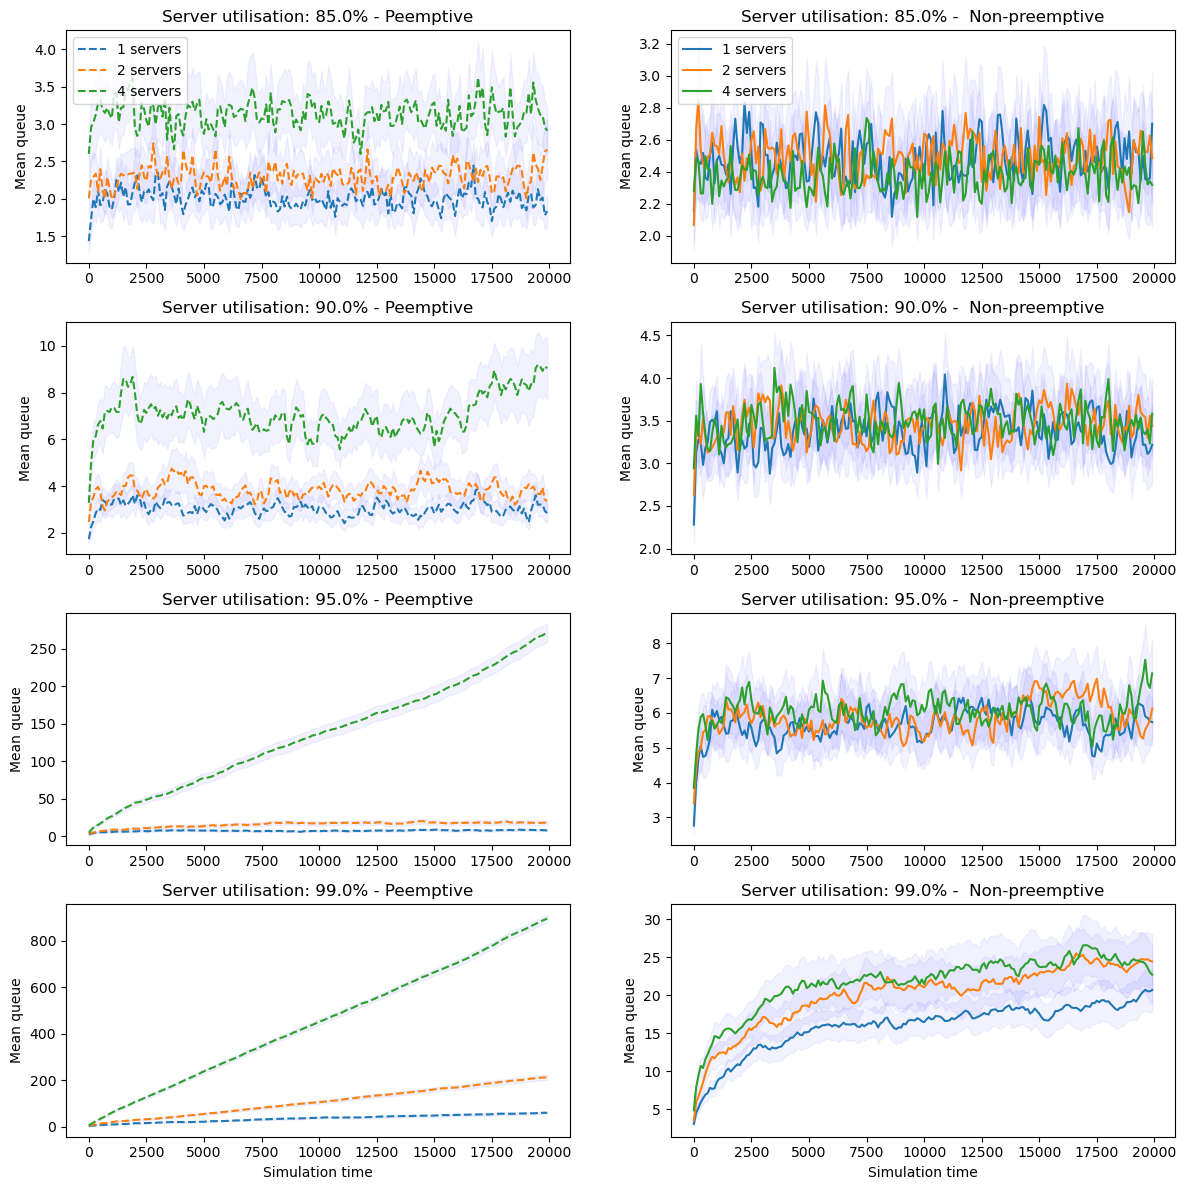

In [820]:
warnings.simplefilter(action='ignore', category=UserWarning)
def extract_res_for_plt(dataframe, numb_serv, p_val):
    mask_severs = dataframe["Server_Count"] == numb_serv
    mask_p_value =  dataframe["P_Value"] == p_val
    filted_set = dataframe[mask_severs]
    filted_set_f2 = filted_set[mask_p_value]
    filtered_datasetos = filted_set_f2["Mean_Queue_Length"]
    filtered_datasetos_cl_l = filted_set_f2["CI_Lower_Bound"]
    filtered_datasetos_cl_u = filted_set_f2["CI_Upper_Bound"]
    return filtered_datasetos, filtered_datasetos_cl_l, filtered_datasetos_cl_u

fig = plt.figure(figsize=(12, 12))  
outer_grid = gridspec.GridSpec(4, 1, fig)  

for i, util in enumerate([0.85, 0.9, 0.95, 0.99]):
    inner_grid = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_grid[i])
    
    ax1 = plt.Subplot(fig, inner_grid[0])
    fig.add_subplot(ax1)
    for pp in serv:
        y, low, up = extract_res_for_plt(mean_queue_lengths_non_pe, pp, util)
        ax1.plot(ma, y, label=f"{pp} servers", linestyle='--')
        ax1.fill_between(ma, low, up, color='b', alpha=0.05)
    
    ax1.set_ylabel("Mean queue")
    ax1.set_title(f"Server utilisation: {util*100}% - Peemptive")
    if i == 0:
        ax1.legend(loc='upper left')

    ax2 = plt.Subplot(fig, inner_grid[1])
    fig.add_subplot(ax2)
    for pp in serv:
        y, low, up = extract_res_for_plt(mean_std_ci_queue_lengths, pp, util)
        ax2.plot(ma, y, label=f"{pp} servers")
        ax2.fill_between(ma, low, up, color='b', alpha=0.05)

    ax2.set_ylabel("Mean queue")
    ax2.set_title(f"Server utilisation: {util*100}% -  Non-preemptive")
    if i == 0:
        ax2.legend(loc='upper left')

    if i == 3:  # Add X-label only to the last subplot
        ax1.set_xlabel("Simulation time")
        ax2.set_xlabel("Simulation time")

plt.tight_layout()
plt.show()


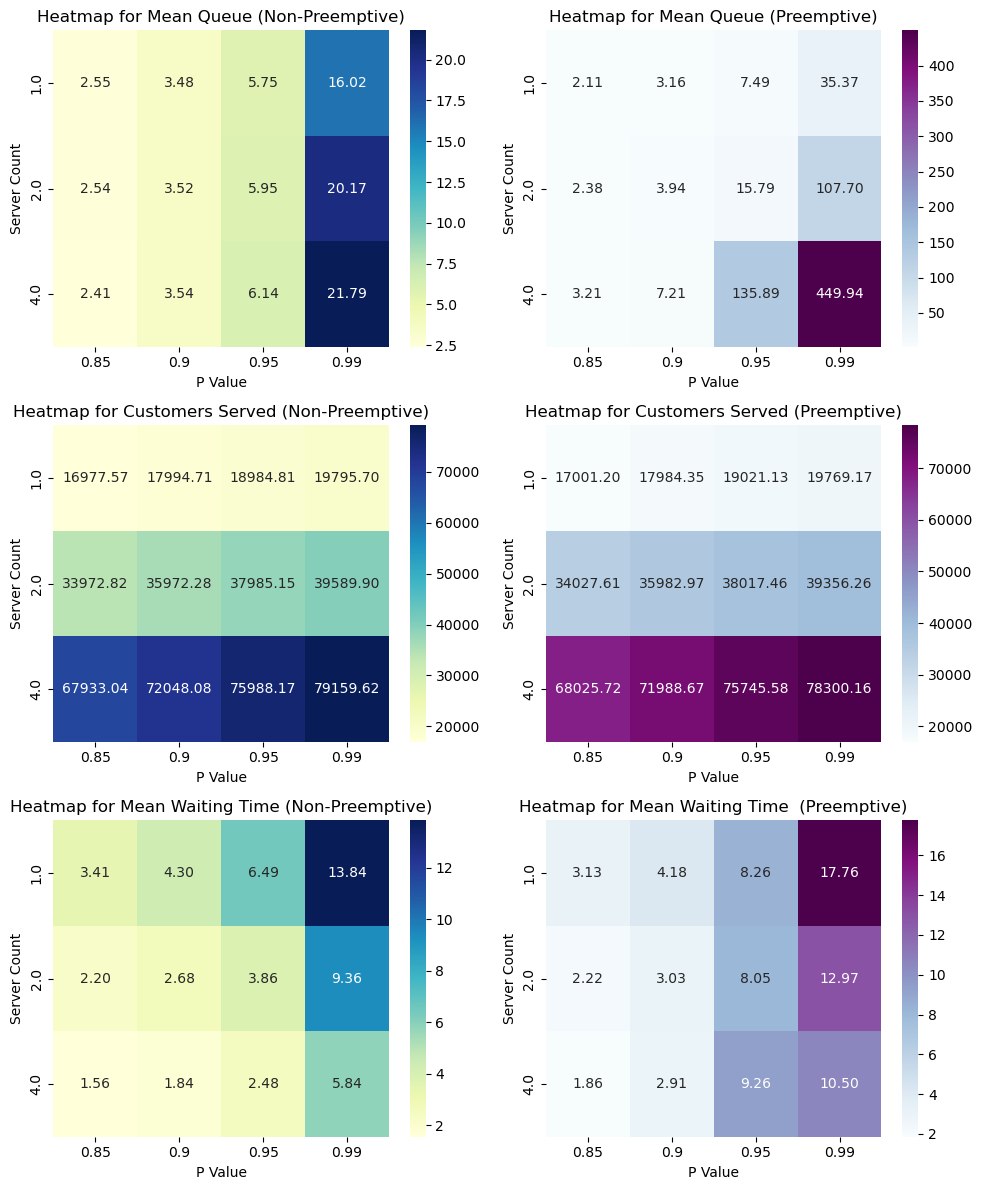

In [817]:
def plot_heatmap(df, col_name, ax, rn, col):
    heatmap_data = df.pivot_table(index='Server_Count', columns='P_Value', values=col_name, aggfunc=np.mean)
    sns.heatmap(heatmap_data, annot=True, cmap=col, fmt=".2f", ax=ax)
    ax.set_xlabel("P Value")
    ax.set_ylabel("Server Count")
    ax.set_title(f"Heatmap for {rn}")   

fig, axs = plt.subplots(3, 2, figsize=(10, 12)) 

of_int = ["Mean_queue","Mean_queue", "Customers_Served",  "Customers_Served",  "Mean_Waiting_time", "Mean_Waiting_time",]
of_int_norm = ["Mean Queue (Non-Preemptive)", "Mean Queue (Preemptive)", "Customers Served (Non-Preemptive)", "Customers Served (Preemptive)", "Mean Waiting Time (Non-Preemptive)", "Mean Waiting Time  (Preemptive)"]

for i, col_name in enumerate(of_int):
    ax = axs[i//2, i%2]
    if i % 2 == 0:
        plot_heatmap(waiting_time_general_stat, col_name, ax,of_int_norm[i], "YlGnBu")
    else:
        plot_heatmap(waiting_time_general_stat_non_pre, col_name, ax,of_int_norm[i], "BuPu")
plt.tight_layout()  
plt.show()  


In [743]:
mean_std_ci_waiting_time_non_pre

,Server_Count,P_Value,Time_Second,Mean_Waiting_time,Std_Dev_Waiting_time,CI_Lower_Bound,CI_Upper_Bound
0,1.0,0.85,100.0,2.119575,0.636670,1.994788,2.244363
1,1.0,0.85,200.0,2.640657,0.939968,2.456423,2.824891
2,1.0,0.85,300.0,2.838394,1.295479,2.584480,3.092308
3,1.0,0.85,400.0,3.009684,1.649732,2.686337,3.333032
4,1.0,0.85,500.0,3.138535,1.529199,2.838812,3.438258
...,...,...,...,...,...,...,...
2395,4.0,0.99,19600.0,12.586772,24.932082,7.700084,17.473461
2396,4.0,0.99,19700.0,10.619865,15.466618,7.588408,13.651322
2397,4.0,0.99,19800.0,12.594309,22.000458,8.282219,16.906398
2398,4.0,0.99,19900.0,12.742866,24.588979,7.923426,17.562305


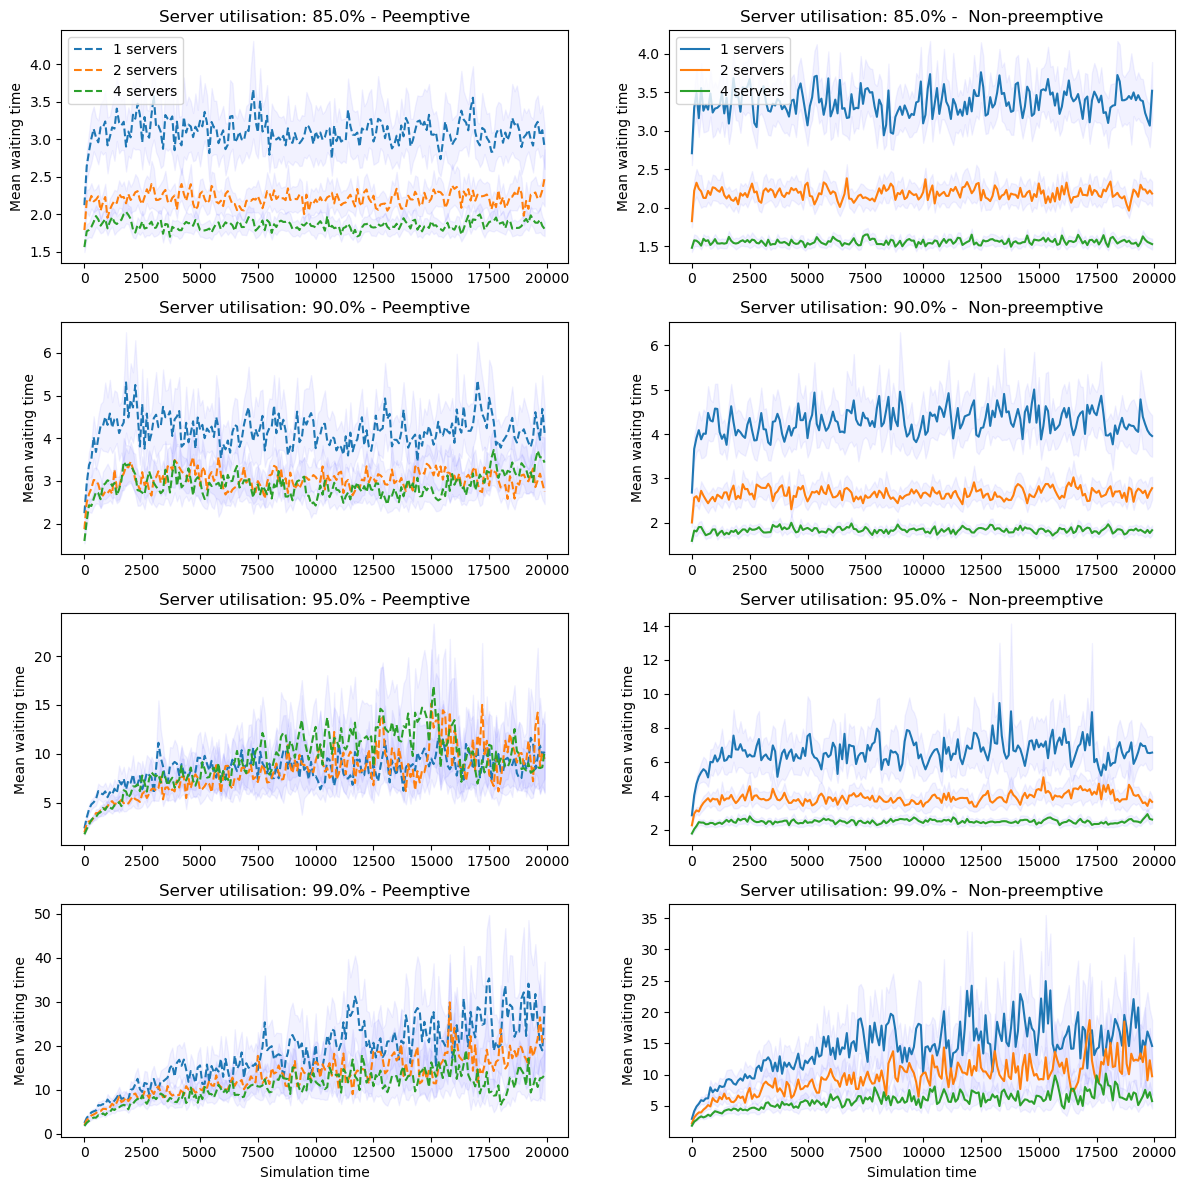

In [821]:

warnings.simplefilter(action='ignore', category=UserWarning)

def extract_res_for_plt(dataframe, numb_serv, p_val):
    mask_severs = dataframe["Server_Count"] == numb_serv
    mask_p_value =  dataframe["P_Value"] == p_val
    filted_set = dataframe[mask_severs]
    filted_set_f2 = filted_set[mask_p_value]
    filtered_datasetos = filted_set_f2["Mean_Waiting_time"]
    filtered_datasetos_cl_l = filted_set_f2["CI_Lower_Bound"]
    filtered_datasetos_cl_u = filted_set_f2["CI_Upper_Bound"]
    return filtered_datasetos, filtered_datasetos_cl_l, filtered_datasetos_cl_u

fig = plt.figure(figsize=(12, 12))  
outer_grid = gridspec.GridSpec(4, 1, fig)  

for i, util in enumerate([0.85, 0.9, 0.95, 0.99]):
    inner_grid = gridspec.GridSpecFromSubplotSpec(1, 2, subplot_spec=outer_grid[i])
    
    ax1 = plt.Subplot(fig, inner_grid[0])
    fig.add_subplot(ax1)
    for pp in serv:
        y, low, up = extract_res_for_plt(mean_std_ci_waiting_time_non_pre, pp, util)
        ax1.plot(ma, y, label=f"{pp} servers", linestyle='--')
        ax1.fill_between(ma, low, up, color='b', alpha=0.05)
    
    ax1.set_ylabel("Mean waiting time")
    ax1.set_title(f"Server utilisation: {util*100}% - Peemptive")
    if i == 0:
        ax1.legend(loc='upper left')

    ax2 = plt.Subplot(fig, inner_grid[1])
    fig.add_subplot(ax2)
    for pp in serv:
        y, low, up = extract_res_for_plt(mean_std_ci_waiting_time, pp, util)
        ax2.plot(ma, y, label=f"{pp} servers")
        ax2.fill_between(ma, low, up, color='b', alpha=0.05)

    ax2.set_ylabel("Mean waiting time")
    ax2.set_title(f"Server utilisation: {util*100}% -  Non-preemptive")
    if i == 0:
        ax2.legend(loc='upper left')

    if i == 3:  # Add X-label only to the last subplot
        ax1.set_xlabel("Simulation time")
        ax2.set_xlabel("Simulation time")

plt.tight_layout()
plt.show()


In [744]:
mean_queue_lengths_non_pe

,Server_Count,P_Value,Time_Second,Mean_Queue_Length,Std_Dev_Queue_Length,CI_Lower_Bound,CI_Upper_Bound
0,1.0,0.85,100.0,1.432256,0.751290,1.285003,1.579509
1,1.0,0.85,200.0,1.728727,1.003646,1.532012,1.925442
2,1.0,0.85,300.0,1.997563,1.256810,1.751228,2.243897
3,1.0,0.85,400.0,1.885692,1.106377,1.668842,2.102542
4,1.0,0.85,500.0,2.113073,1.438313,1.831163,2.394982
...,...,...,...,...,...,...,...
2395,4.0,0.99,19600.0,878.600037,80.333757,862.854621,894.345454
2396,4.0,0.99,19700.0,882.911317,80.584292,867.116796,898.705838
2397,4.0,0.99,19800.0,887.966047,79.932293,872.299318,903.632777
2398,4.0,0.99,19900.0,892.062409,79.932971,876.395547,907.729271


In [800]:
waiting_time_general_stat_non_pre

,Server_Count,P_Value,Mean_Waiting_time,Mean_Within_Std_of_Waiting_time,Customers_Served,Mean_queue,Std_within_Waiting_time,Std_Dev_Waiting_time,Std_Dev_Customers_served,Std_Dev_Queue,...,CI_Lower_Bound_Customers_Served,CI_Upper_Bound_Customers_Served,CI_Lower_Bound_Queue,CI_Upper_Bound_Queue,Min_waiting_time,Max_waiting_time,Min_queue,Max_queue,Min_customers_served,Max_customers_served
0,1.0,0.85,3.126343,11.365760,17001.20,2.111362,2.381135,0.220015,141.244611,2.111362,...,16973.516056,17028.883944,1.697535,2.525189,0.000643,1274.884857,0.0,22.0,16623.0,17438.0
1,1.0,0.90,4.182395,20.972909,17984.35,3.156649,5.556820,0.421372,135.044983,3.156649,...,17957.881183,18010.818817,2.537946,3.775352,0.000473,2339.220833,0.0,29.0,17608.0,18292.0
2,1.0,0.95,8.260296,77.062443,19021.13,7.493724,39.640747,2.210317,134.307011,7.493724,...,18994.805826,19047.454174,6.024954,8.962494,0.000352,13241.330108,0.0,48.0,18653.0,19328.0
3,1.0,0.99,17.756719,224.180249,19769.17,35.374385,84.847352,5.051461,129.572609,35.374385,...,19743.773769,19794.566231,28.441006,42.307765,0.000406,18190.513387,0.0,172.0,19479.0,20081.0
4,2.0,0.85,2.219200,7.065037,34027.61,2.376781,1.142389,0.102966,166.874557,2.376781,...,33994.902587,34060.317413,1.910932,2.842630,0.000078,731.184806,0.0,26.0,33505.0,34477.0
5,2.0,0.90,3.033582,15.586124,35982.97,3.944746,4.859565,0.256544,157.172546,3.944746,...,35952.164181,36013.775819,3.171576,4.717916,0.000230,3427.757946,0.0,46.0,35671.0,36342.0
6,2.0,0.95,8.046640,103.894706,38017.46,15.789497,65.195183,2.987290,188.209746,15.789497,...,37980.570890,38054.349110,12.694755,18.884238,0.000096,18292.388657,0.0,102.0,37581.0,38575.0
7,2.0,0.99,12.970518,185.401023,39356.26,107.704479,62.119331,2.960483,177.719083,107.704479,...,39321.427060,39391.092940,86.594401,128.814556,0.000412,18855.440444,0.0,387.0,38787.0,39719.0
8,4.0,0.85,1.860116,5.723286,68025.72,3.211347,0.874521,0.072299,265.978649,3.211347,...,67973.588185,68077.851815,2.581923,3.840771,0.000066,688.336084,0.0,32.0,67266.0,68571.0
9,4.0,0.90,2.905841,20.538380,71988.67,7.205317,7.402842,0.331350,292.526616,7.205317,...,71931.334783,72046.005217,5.793075,8.617559,0.000010,4309.390843,0.0,62.0,71381.0,72734.0


In [808]:

dataset1 = waiting_time_general_stat 
dataset2 = waiting_time_general_stat_non_pre 
server_counts = dataset1['Server_Count'].unique()
p_values = dataset1['P_Value'].unique()

for server_count in server_counts:
    for p_value in p_values:
        subset1 = dataset1[(dataset1['Server_Count'] == server_count) & (dataset1['P_Value'] == p_value)]
        subset2 = dataset2[(dataset2['Server_Count'] == server_count) & (dataset2['P_Value'] == p_value)]

        if not subset1.empty and not subset2.empty:
            t_stat, p_waiting = stats.ttest_ind_from_stats(
                mean1=subset1['Mean_Waiting_time'].mean(), std1=subset1['Std_Dev_Waiting_time'].mean(), nobs1=100,
                mean2=subset2['Mean_Waiting_time'].mean(), std2=subset2['Std_Dev_Waiting_time'].mean(), nobs2=100,
                equal_var=False
            )

            t_stat, p_customers = stats.ttest_ind_from_stats(
                mean1=subset1['Customers_Served'].mean(), std1=subset1['Std_Dev_Customers_served'].mean(), nobs1=100,
                mean2=subset2['Customers_Served'].mean(), std2=subset2['Std_Dev_Customers_served'].mean(), nobs2=100,
                equal_var=False
            )

            t_stat, p_queue = stats.ttest_ind_from_stats(
                mean1=subset1['Mean_queue'].mean(), std1=subset1['Std_Dev_Queue'].mean(), nobs1=100,
                mean2=subset2['Mean_queue'].mean(), std2=subset2['Std_Dev_Queue'].mean(), nobs2=100,
                equal_var=False
            )

            print(f"Server_Count: {server_count}, P_Value: {p_value}")
            print(f"Mean_Waiting_time p-value: {p_waiting}")
            print(f"Customers_Served p-value: {p_customers}")
            print(f"Mean_queue p-value: {p_queue}")
            print("\n")

Server_Count: 1.0, P_Value: 0.85
Mean_Waiting_time p-value: 2.2358073460474544e-18
Customers_Served p-value: 0.2108034643833527
Mean_queue p-value: 0.19020485308621882


Server_Count: 1.0, P_Value: 0.9
Mean_Waiting_time p-value: 0.03785886965880834
Customers_Served p-value: 0.574881437297294
Mean_queue p-value: 0.49849141281584286


Server_Count: 1.0, P_Value: 0.95
Mean_Waiting_time p-value: 3.134704055203598e-11
Customers_Served p-value: 0.05693455256303483
Mean_queue p-value: 0.0672658052628399


Server_Count: 1.0, P_Value: 0.99
Mean_Waiting_time p-value: 2.9171142366541003e-09
Customers_Served p-value: 0.1638665166342601
Mean_queue p-value: 1.8367365002032703e-06


Server_Count: 2.0, P_Value: 0.85
Mean_Waiting_time p-value: 0.12610806815706874
Customers_Served p-value: 0.022824409236341513
Mean_queue p-value: 0.6332778824887481


Server_Count: 2.0, P_Value: 0.9
Mean_Waiting_time p-value: 2.39441749254339e-24
Customers_Served p-value: 0.6621899745361723
Mean_queue p-value: 0.42561260